# Tutorial 2.3: Models Based on Extensions of the LIF Neuron

## Neuroscience goal: 
- understand the reciprocal impacts of adaptation currents on spike trains and spike trains on adaptation currents
- understand how limits on the firing rate and mean membrane potential depend on the spiking mechanism

## Computational goals:
- simulate coupled differential equations with two variables
- analyze simulation restults and plot appropriate features of the simulation
    - e.g., depending on the number of spikes produced


### Tutorial overview
- will analyze the impact of adaptation currents on the f-I curve of a neuron

### Question 1: LIF model with adaptation current
simulate the LIF model with an adaptation current so the full model becomes: 
$$ C_m \frac{dV}{dt} = (E_l - V)/R_m + G_{SRA}(E_k - V) + I_{app} $$
and
$$ \frac{dG_{SRA}}{dt} = -G_{SRA} / \tau_{SRA} $$

with the rule that if $V > V_m$ then $V \rightarrow V_{reset}$ and $G_{SRA} \rightarrow G_{SRA} + \Delta G_{SRA}$

Use the parameters:
- e_leak = -75mV
- v_threshold = -50mV
- v_reset = -80mV
- r_membrane = 100 M Ohm
- c_membrane = 100 pF
- e_potassium = -80mv
- delta_g_sra = 1 nS
- tau_sra = 200ms

Initially set V = e_leak and g_sra = 0

### 1a. 
- simulate the model neuron for 1.5s with a current pulse of i_app = 500 pA applied from 0.5s to 1.0s
- plot your results in a graph, using three subplots with:
    - the current as a function of time
    - the membrane potential as a function of time
    - adaptation conductance as a function of time
   

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def reset_params(i_mult=1.1):
    """
    Reset global parameters and initialize variables for a simulation.
    """
    global e_leak, v_threshold, v_reset, v_peak, r_membrane, c_membrane, g_leak, e_k, delta_g_sra, \
    tau_sra, tau_m, a, delta_th, b, tmax, dt, t, v, g_sra, i_app, i_threshold


    # Set parameters

    e_leak = -75                  # Leak/resting potential, mV
    v_threshold = -50             # Spike threshold, mV
    v_reset = -80                 # Reset potential, mV
    v_peak = 50                   # Spike peak, mV
    r_membrane = 100e6            # Membrane resistance, Ohm
    c_membrane = 1e-10            # Capacitance, F
    g_leak = 10e-9
    e_k = -80                     # Potassium leak potential
    delta_g_sra = 1e-9            # Conductance step, Siemens
    tau_sra = 2e-1                # SRA time constant
    tau_m = r_membrane*c_membrane # Vm decay time constant
    a = 2e-9
    delta_th = 2e-3
    b = 2e-11

    # Initialize time vectors
    tmax = 1.5             # Time duration, s
    dt = 1e-3              # Time step, s
    t = np.arange(0, tmax, dt)

    # Initialize membrane potential vector
    v = np.zeros_like(t)
    v[0] = e_leak
    # Initialize SRA conductance vector
    g_sra = np.zeros_like(t)
    g_sra[0] = 0

    # Initialize applied current vector
    pulse_start = 0.5
    pulse_end = 1.0
    i_app = np.zeros_like(t)
    i_threshold = (v_threshold - e_leak) / r_membrane
    i_0 = i_threshold
    i_app[(t >= pulse_start) & (t <= pulse_end)] = i_0 * i_mult
reset_params()

In [8]:
# Define functions
def run_lif(v=v, g_sra=g_sra, i_app=i_app, sigma=0):
    """
    Simulate the responseof a neuron to an applied current pulse
    
    Args:
        i_app (ndarray): array of applied current over time
        sigma (float): noise value
    Returns:
        v (ndarray): array of membrane potential values
        g_sra (ndarray): array of SRA conductance values
    
    """
    v_sim = np.zeros_like(t)
    v_sim[0] = v[0]
    g_sim = np.zeros_like(t)
    g_sim[0] = g_sra[0]
        
    # Iterate over time step
    for i in range(1, t.shape[0]):
        
        noise = np.random.randn() * sigma * np.sqrt(dt)
        
        # Membrane potential ODE
        dvdt = (((e_leak - v_sim[i - 1]) / r_membrane) + ((g_sim[i - 1] * (e_k - v_sim[i - 1])) + i_app[i])) / c_membrane
        # Forward Euler update for membrane potential
        v_sim[i] = v_sim[i - 1] + (dt * dvdt) + noise             
        
        # SRA Conductance ODE
        dgdt = -g_sim[i - 1] / tau_sra
        # Forward Euler update for conductance
        g_sim[i] = g_sim[i - 1] + (dt * dgdt)
        
        if v_sim[i] >= v_threshold:                       # Spike
            v_sim[i] = v_reset                            # Reset Vm
            g_sim[i] = g_sim[i] + delta_g_sra             # Update conductance 
            v_sim[i - 1] = v_peak                         # Add Vm uptick
    
    return v_sim, g_sim

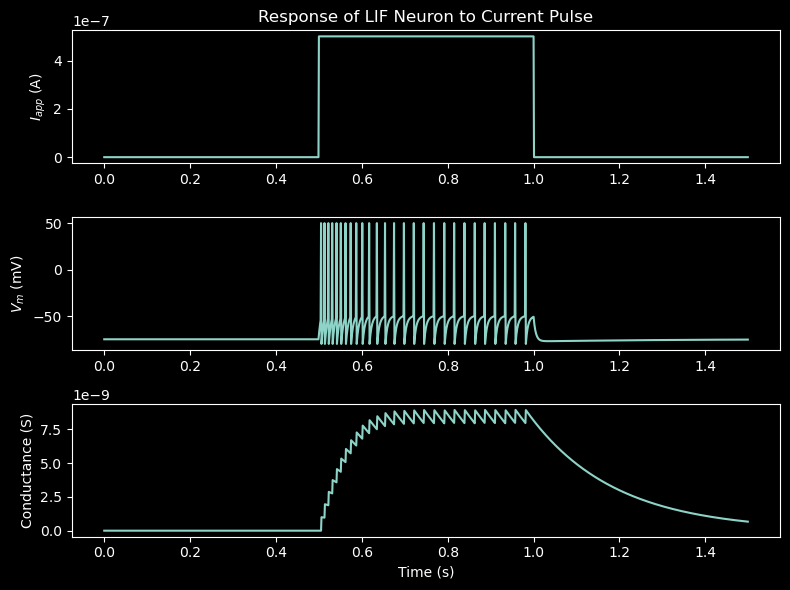

In [9]:
# Run simulation
reset_params(2)
v_sim, g_sim = run_lif(v, g_sra, i_app, 0)

# Plot applied current, membrane potential, SRA conductance as function of time
fig, ax = plt.subplots(3, 1, figsize=(8, 6))

# Plot applied current
ax[0].plot(t, i_app)
ax[0].set_ylabel('$I_{app}$ (A)')
ax[0].set_title('Response of LIF Neuron to Current Pulse')

# Plot membrane potential
ax[1].plot(t, v_sim)
ax[1].set_ylabel('$V_m$ (mV)')

# Plot SRA conductance
ax[2].plot(t, g_sim)
ax[2].set_ylabel('Conductance (S)')
ax[2].set_xlabel('Time (s)')

fig.tight_layout()
plt.show()

### 1b.
- simulate the model for 5s with a range of 20 different levels of constant applied current (i.e., without a step pulse)
    - such that steady state firing rate of the cell varies from 0 to 50 Hz 
- for each applied current, calculate the first interspike interval and the steady-state interspike interval 
- plot the inverse of the steady-state interspike interval against applied current to produce an f-I curve
- on the same graph, plot as individual points (crosses or squares) the inverse of the initial interspike interval. 
- comment on your results
    
    

In [10]:
def count_spikes(v_f, v_peak):
    """
    Count number of spikes in membrane potential array 
    
    Args:
        v (ndarray): array of membrane potential values
        v_peak (float): threshold value for detecting spikes
    Returns:
        number of spikes detected
    """ 
    return np.sum(v_f == v_peak)
    
def get_rates(currents):
    """
    Calculate firing rate for different current values
    
    Returns:
        firing_rates (ndarray): array containing firing rates (Hz) for each current value
    """
    
    # Initialize firing_rates array
    firing_rates = np.zeros_like(currents)
    
    # Iterate over currents
    for i in range(currents.shape[0]):
        # Reset simulation each time
        v = np.zeros_like(t)
        v[0] = e_leak
        i_0 = currents[i]
        i_app = np.full_like(t, i_0)
        g_sra = np.zeros_like(t)
        g_sra[0] = 0
        
        # Run simulation
        v, g_sra = run_lif(v, g_sra, i_app, sigma=0)
        
        # Calculate spike rate
        num_spikes = np.sum(v == v_peak)
        spike_rate = num_spikes / tmax
        firing_rates[i] = spike_rate
        
    return firing_rates

def first_isi(v, spike):
    spike_indices = np.where(v == spike)[0]
    if len(spike_indices) >= 2:
        first_isi = (spike_indices[1] - spike_indices[0]) * dt
        return first_isi
    else:
        return 0
    
def last_isi(v, spike):
    spike_indices = np.where(v == spike)[0]
    if len(spike_indices) >= 2:
        last_isi = (spike_indices[-1] - spike_indices[-2]) * dt
        return last_isi
    else:
        return 0

In [14]:
reset_params()
# Simulate for 5s
t = np.arange(0, 5, dt*10)
currents = np.linspace(i_threshold*0.9, i_threshold*2, 20)

# Steady state potential
ss_potential = np.zeros_like(currents)  
for i in range(currents.shape[0]):
    # Find steady state potential for each current value
    ss_potential[i] = e_leak + currents[i] * r_membrane

# Steady state ISI
ss_isi = np.zeros_like(currents)
first_spikes = np.zeros_like(currents)
initial_isi = np.zeros_like(currents)
steady_isi = np.zeros_like(currents)

for i in range(currents.shape[0]):
    i_app = np.full_like(t, currents[i])
    v, g = run_lif(i_app=i_app)
    
    # Find initial ISI for each current value
    initial_isi[i] = first_isi(v, v_peak)
    # Find simulated ISI for steady state
    steady_isi[i] = last_isi(v, v_peak)
    
# Prevent divide by 0 error
initial_isi = np.where(initial_isi == 0, 10e8, initial_isi)
steady_isi = np.where(steady_isi == 0, 10e8, steady_isi)


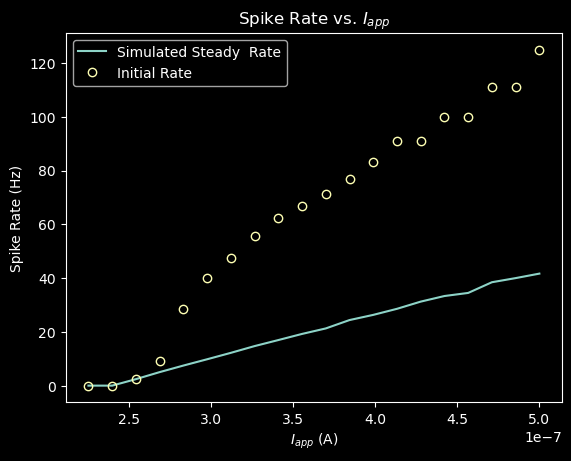

In [15]:
plt.plot(currents, 1/steady_isi, label='Simulated Steady  Rate')
plt.plot(currents, 1/initial_isi, 'o', mfc='none', label='Initial Rate')
plt.title('Spike Rate vs. $I_{app}$')
plt.ylabel('Spike Rate (Hz)')
plt.xlabel('$I_{app}$ (A)')
plt.legend()
plt.show()

### Question 2

Write a code to simulate the AELIF model:

$$ C_m \frac{dV}{dt} = G_L[(E_l - V_m + \Delta_{th}exp(\frac{V_m - V_{th}}{\Delta_{th}})] - I_{SRA} + I_{app} $$

$$\tau_{SRA}\frac{dI_{SRA}}{dt} = a(V_m - E_L) - I_{SRA}  $$

while:

if $$V_m > V_{max}\;then\; V \rightarrow V_{reset} \;and\; I_{SRA} \rightarrow I_{SRA} + b$$

Use parameters:
- e_leak = -75mV
- v_threshold = -50mV
- v_reset = -80mV
- delta_th = 2mV
- g_leak = 10nS
- c_membrane = 100pF
- a = 2nS
- b = 0.02nA
- tau_sra = 200ms

initially set v = e_leak and i_sra = 0

### 2a. 
Simulate the model neuron for 1.5s, with a current pulse of i_app = 500pA applied from 0.5s to 1.0s. Plot results in a graph, using two subplots with the current as a function of time plotted above the membrane potential as a function of time


In [16]:
def run_aelif(v=v, i_app=i_app, sigma=0):
    
    v_sim = np.zeros_like(t)
    v_sim[0] = e_leak
    i_sra = np.zeros_like(t)
    i_sra[0] = 0
    
    for i in range(1, t.shape[0]):
        # New noise term each simulation
        noise = np.random.rand() * sigma * np.sqrt(dt)
        
        # Membrane potential ODE
        dvdt = (g_leak*((e_leak - v_sim[i - 1]) + delta_th * np.exp((v_sim[i - 1] - v_threshold)/delta_th)) - i_sra[i - 1] + i_app[i]) / c_membrane
        # Forward Euler update
        v_sim[i] = v_sim[i - 1] + (dt * dvdt) + noise
        
        # SRA current ODE
        didt = ((a * (v_sim[i - 1] - e_leak)) - i_sra[i - 1]) / tau_sra
        # Forward Euler update
        i_sra[i] = i_sra[i - 1] + (dt * didt) + noise
        
        if v_sim[i] >= v_threshold:
            v_sim[i] = v_reset
            i_sra[i] = i_sra[i] + b
            v_sim[i - 1] = v_peak
        
    return v_sim, i_sra

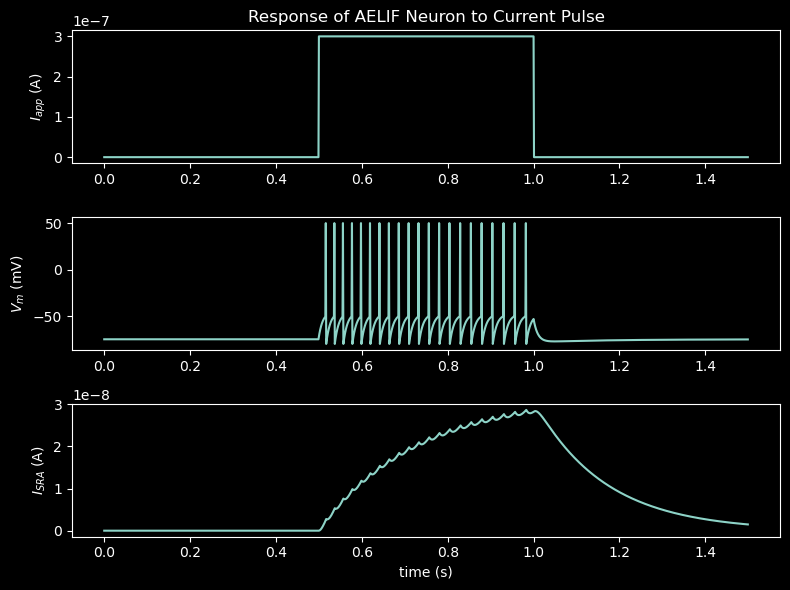

In [17]:
# Run simulation
reset_params(1.2)
v_sim, i_sim = run_aelif(v, i_app, 0)

# Plot applied current, membrane potential, SRA conductance as function of time
fig, ax = plt.subplots(3,1, figsize=(8, 6))
ax[0].plot(t, i_app)
ax[0].set_ylabel('$I_{app}$ (A)')
ax[0].set_title('Response of AELIF Neuron to Current Pulse')
ax[1].plot(t, v_sim)
ax[1].set_ylabel('$V_m$ (mV)')
ax[2].plot(t, i_sim)
ax[2].set_ylabel('$I_{SRA}$ (A)')
ax[2].set_xlabel('time (s)')

plt.tight_layout()
plt.show()


### 2b.
Simulate the model for 5s with a range of 20 different levels of constant applied current such that the steady state firing rate of the cell varies from zero to 50 Hz. 
- For each applied current, calculate the first ISI and the steady-state ISI. On a graph plot the inverse of the steady-state ISI against applied current to produce an f-I curve.
- On the same graph, plot as individual points the inverse of the initial ISI. 
- Comment on your results

In [18]:
reset_params()
# Simulate for 5s
t = np.arange(0, 5, dt)
currents = np.linspace(i_threshold*0.9, i_threshold*2, 20)

steady_isi = np.zeros_like(currents)
initial_isi = np.zeros_like(currents)

for i in range(currents.shape[0]):
    i_app = np.full_like(t, currents[i])
    v, i_sim = run_aelif(i_app=i_app)
    
    initial_isi[i] = first_isi(v, v_peak)
    steady_isi[i] = last_isi(v, v_peak)
    
# Prevent divide by 0 error
initial_isi = np.where(initial_isi == 0, 10e8, initial_isi)
steady_isi = np.where(steady_isi == 0, 10e8, steady_isi)


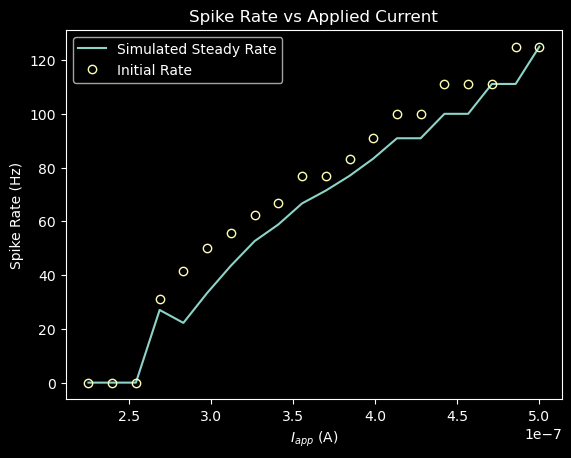

In [19]:
# Plot inverse of initial and steady-state ISI to make f-I curve
plt.plot(currents, 1/steady_isi, label='Simulated Steady Rate')
plt.plot(currents, 1/initial_isi, 'o', mfc='none', label='Initial Rate')
plt.title('Spike Rate vs Applied Current')
plt.ylabel('Spike Rate (Hz)')
plt.xlabel('$I_{app}$ (A)')
plt.legend()
plt.show()